In [1]:
import torch
import torchvision
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import tqdm
import datasets
from utils import get_params_count_summary
import json
import time
import copy

import pprint
pp = pprint.PrettyPrinter(width=128, compact=True)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
DEVICE = "cuda"

import sys
sys.path.append('segmentation/')
from segmentation import Segmenter, visualized_masks


import datasets
from data.sharegpt4v import ShareGPT4V
from data.clevr import CLEVR

from transformers import CodeGenTokenizerFast
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import pycocotools.mask as mask_util
import pickle
from model.multimodal_tokenizer import MultimodalTokenizer

from transformers import (
    TrainingArguments,
    Trainer
)
from peft import LoraConfig, PeftModel, get_peft_model


/home/dchenbs/anaconda3/envs/seq2seq-ae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LLM Ablation

In [2]:
# import torch
# from transformers import AutoModelForCausalLM, AutoTokenizer

# torch.set_default_device("cuda")

# model = AutoModelForCausalLM.from_pretrained("/home/dchenbs/workspace/Seq2Seq-AutoEncoder/runs/phi-2-multimodal/checkpoint-200", torch_dtype="auto", trust_remote_code=True)
# # model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5", torch_dtype="auto", trust_remote_code=True)
# tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)


In [3]:

# inputs = tokenizer('''### Human:\nExplain the visual content of the image in great detail.<|endoftext|>\n### AI: ''', return_tensors="pt", return_attention_mask=False)

# outputs = model.generate(**inputs, max_length=200)
# text = tokenizer.batch_decode(outputs)[0]
# print(text)


### Model

In [4]:

from model.seq2seq_autoencoder import Seq2SeqAutoEncoderModel
from model.modeling_multimodal_phi import PhiForMultimodalModeling, load_seqae

ckpt = "/home/dchenbs/workspace/Seq2Seq-AutoEncoder/runs/phi-2-multimodal/checkpoint-5000"

model = PhiForMultimodalModeling.from_pretrained(
    "microsoft/phi-2",
    # "/home/dchenbs/workspace/Seq2Seq-AutoEncoder/runs/phi-2-multimodal/checkpoint-50",
    w_segment_loss=1.0,
    w_bbox_loss=1/(1000*1000),
    seqae_batch_size=32,
    )

seqae = Seq2SeqAutoEncoderModel.from_pretrained('/home/dchenbs/workspace/Seq2Seq-AutoEncoder/runs/Jan02_11-49-33_host19-SA1B-[327MB-16queries-1024]-[lr1e-05-bs16x1step-8gpu]/checkpoints/checkpoint_step2800k')


load_seqae(model, seqae)

peft_model = PeftModel.from_pretrained(model, ckpt, from_transformers=True)

state_dict = torch.load(ckpt+'/additional_modules.pth', map_location="cpu")
message = peft_model.load_state_dict(state_dict, strict=False)

model = peft_model.merge_and_unload()

model = model.to(DEVICE)


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]
/home/dchenbs/anaconda3/envs/seq2seq-ae/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Tokenizer

In [5]:
# with open('segmentation/mobile_sam_v2_l2.json', 'r') as f:
#     config = json.load(f)
#     pprint.pprint(config)
# segmenter = Segmenter(config['model_name'], config['checkpoint'], **config['kwargs'])

segmenter = None

tokenizer = MultimodalTokenizer.from_pretrained(
    "microsoft/phi-2", trust_remote_code=True, 
    segmenter=segmenter, 
    seqae_config=model.seqae.config, 
    max_seg_per_img=128,
    model_max_length=128,
    )

tokenizer.load_cached_segments(
    # '/home/dchenbs/workspace/Seq2Seq-AutoEncoder/segmentation/cached_segments/sharegpt4v_instruct_gpt4-vision_cap100k')
    '/home/dchenbs/workspace/Seq2Seq-AutoEncoder/segmentation/cached_segments/clevr_val')


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'CodeGenTokenizer'. 
The class this function is called from is 'MultimodalTokenizer'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


added 5000 cached images from part0.pkl, total 5000 cached images now.
added 5000 cached images from part1.pkl, total 10000 cached images now.
added 4998 cached images from part2.pkl, total 14998 cached images now.
Loaded 14998 cached images from /home/dchenbs/workspace/Seq2Seq-AutoEncoder/segmentation/cached_segments/clevr_val, total 14998 cached images now.


In [6]:
# root = '/home/dchenbs/workspace/datasets/CLEVR_v1.0/images/val'
# images = os.listdir(root)
# image_path = os.path.join(root, random.choice(images))

# plt.figure(figsize=(30, 10))

# image = Image.open(image_path)
# plt.subplot(1, 3, 1)
# plt.imshow(image)
# plt.title('original')
# plt.axis('off')

# inputs  = tokenizer([f'<img_path>{image_path}</img_path>'], return_tensors="pt")

# canvas = tokenizer.decode_image(inputs['segment_sequences'][0][0], inputs['bboxes'][0][0])
# plt.subplot(1, 3, 2)
# plt.imshow(canvas)
# plt.title('reconstructed')
# plt.axis('off')

# canvas = tokenizer.decode_image(inputs['segment_sequences'][0][0], inputs['bboxes'][0][0], filling='random')
# plt.subplot(1, 3, 3)
# plt.imshow(canvas)
# plt.axis('off')
# plt.title('segment masks')
# plt.show()

In [7]:

model.resize_token_embeddings(len(tokenizer))
model.special_token_id_mapping = {
    "<|startofimage|>": tokenizer.convert_tokens_to_ids("<|startofimage|>"),
    "<|endofimage|>": tokenizer.convert_tokens_to_ids("<|endofimage|>"),
    "<|seg|>": tokenizer.convert_tokens_to_ids("<|seg|>"),
    "<|endoftext|>": tokenizer.convert_tokens_to_ids("<|endoftext|>"),
    "[PAD]": tokenizer.convert_tokens_to_ids("[PAD]"),
}

### Data

In [8]:

# dataset_path = '/home/dchenbs/workspace/datasets/sharegpt4v/ShareGPT4V'
# dataset_identifier = 'sharegpt4v_instruct_gpt4-vision_cap100k'


dataset_path = '/home/dchenbs/workspace/datasets/CLEVR_v1.0'
dataset_identifier = 'clevr_val'

if 'sharegpt4v' in dataset_identifier:
    annotation_file = os.path.join(dataset_path, dataset_identifier+'.json')
    dataset = ShareGPT4V(annotation_file, split='val')
    failed_samples = dataset.validate_exist(valid_img_paths=tokenizer.cache)
elif 'clevr' in dataset_identifier:
    split = dataset_identifier.split('_')[-1]
    dataset = CLEVR(dataset_path=dataset_path, split=split)
    failed_samples = dataset.validate_exist(valid_img_paths=tokenizer.cache)

  0%|          | 0/15000 [00:00<?, ?it/s]

100%|██████████| 15000/15000 [00:00<00:00, 197894.94it/s]

Found 0 samples failed to load due to file not exist.
Found 2 samples failed to load due to file not exist in provided list.
After validation, 14998 samples left.


### Human: 
Describe this image<img_path>/home/dchenbs/workspace/datasets/CLEVR_v1.0/images/val/CLEVR_val_000001.png</img_path><|endoftext|>
### AI: 
Total 10 objects: a large gray metal cylinder, a small green metal cylinder, a small yellow rubber cylinder, a small cyan metal cube, a small blue metal cylinder, a small cyan rubber cylinder, a small yellow metal cube, a large blue metal cube, a large purple metal sphere, a large blue rubber cylinder.<|endoftext|>


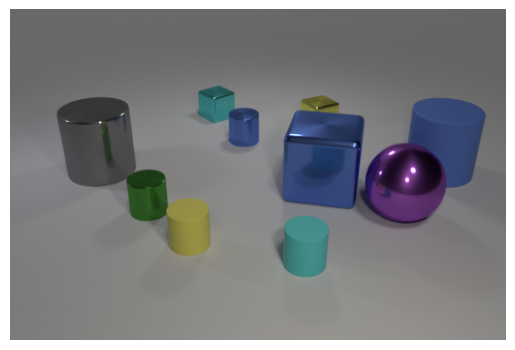

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


### Human: 
Describe this image<|startofimage|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|seg|><|endofimage|><|endoftext|>
### AI: 
Total 10 objects: a large blue metal cylinder, a small blue metal sphere, a small blue metal cylinder, a small blue metal cube, a small blue metal cylinder, a small blue metal cylinder, a large blue metal cylinder, a small red metal cube, a large blue metal cylinder, a large red rubber cylinder.<|endoftext|>


In [11]:
sample_idx = 1

print(dataset[sample_idx])

img_path = dataset.__getitem__(sample_idx, only_return_img_path=True)
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

inputs  = tokenizer([
    # '### Human:\nExplain the visual content of the image in great detail. <img_path>/home/dchenbs/workspace/datasets/CLEVR_v1.0/images/test/CLEVR_test_000000.png</img_path><|endoftext|>\n### AI: ',
    dataset[sample_idx].split('### AI: \n')[0] + '### AI:'
    # 'My name is Mariama, my favorite'
    ], return_tensors="pt", return_attention_mask=False, padding=True)


inputs['input_ids'] = inputs['input_ids'].to(DEVICE)
inputs['segment_sequences'] = [segment_sequence.to(DEVICE) for segment_sequence in inputs['segment_sequences']]
inputs['bboxes'] = [bbox.to(DEVICE) for bbox in inputs['bboxes']]

outputs = model.generate(
    # **inputs, 
    input_ids=inputs['input_ids'],
    segment_sequences=inputs['segment_sequences'],
    bboxes=inputs['bboxes'],
    use_cache=False,
    max_length=128)
text = tokenizer.batch_decode(outputs)[0]
print(text)